## Numba Mandelbrot acceleration

The classic Mandelbrot calculation is a good test case for `numba` because the execution time is dominated by an iterative function that isn't trivially vectorized by using `numpy`. You can find many variations of this demo online, but this specific example is based on [this notebook](https://github.com/arasdar/DL/blob/master/impl-dl/etc/misc3/numba-cuda-gpu-example.ipynb).

In [1]:
import numpy as np
from matplotlib.pylab import imshow, show
%matplotlib inline

In [2]:
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  """Iterates over each pixel in the provided image and calls mandel() to compute the color."""
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color



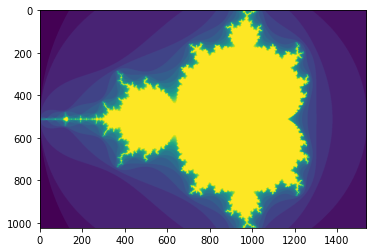

CPU times: user 4.3 s, sys: 22.6 ms, total: 4.32 s
Wall time: 4.34 s


In [3]:
%%time

image = np.zeros((1024, 1536), dtype = np.uint8)
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 

imshow(image)
show()

### Speed this up with `numba`

In [4]:
from numba import jit

The code below is identical to the cell above except for the `@jit` function decorators.

In [5]:
@jit
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

@jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  """Iterates over each pixel in the provided image and calls mandel() to compute the color."""
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color


In [6]:
%%timeit

image = np.zeros((1024, 1536), dtype = np.uint8)
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 

46.5 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


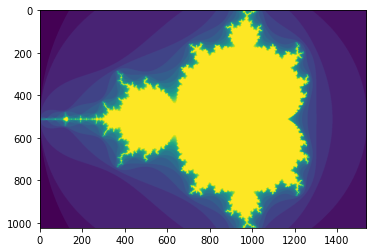

In [7]:
imshow(image)
show()

In [8]:
create_fractal.inspect_types()

create_fractal (float64, float64, float64, float64, array(uint8, 2d, C), int64)
--------------------------------------------------------------------------------
# File: <ipython-input-5-6f810be67772>
# --- LINE 17 --- 

@jit

# --- LINE 18 --- 

def create_fractal(min_x, max_x, min_y, max_y, image, iters):

  # --- LINE 19 --- 

  """Iterates over each pixel in the provided image and calls mandel() to compute the color."""

  # --- LINE 20 --- 
  # label 0
  #   min_x = arg(0, name=min_x)  :: float64
  #   max_x = arg(1, name=max_x)  :: float64
  #   min_y = arg(2, name=min_y)  :: float64
  #   max_y = arg(3, name=max_y)  :: float64
  #   image = arg(4, name=image)  :: array(uint8, 2d, C)
  #   iters = arg(5, name=iters)  :: int64
  #   $4load_attr.1 = getattr(value=image, attr=shape)  :: UniTuple(int64 x 2)
  #   $const6.2 = const(int, 0)  :: Literal[int](0)
  #   $8binary_subscr.3 = static_getitem(value=$4load_attr.1, index=0, index_var=$const6.2)  :: int64
  #   del $const6.2
  #   

In [9]:
from numba import prange

@jit(parallel=True)
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  """Iterates over each pixel in the provided image and calls mandel() to compute the color."""
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in prange(width):
    real = min_x + x * pixel_size_x
    for y in prange(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color

In [10]:
%%timeit

image = np.zeros((1024, 1536), dtype = np.uint8)
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 

The slowest run took 4.53 times longer than the fastest. This could mean that an intermediate result is being cached.
25 ms ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
create_fractal.parallel_diagnostics(level=2)

 
 Parallel Accelerator Optimizing:  Function create_fractal, <ipython-
input-9-1a8faf947992> (3)  


Parallel loop listing for  Function create_fractal, <ipython-input-9-1a8faf947992> (3) 
---------------------------------------------------------------------------------------------------|loop #ID
@jit(parallel=True)                                                                                | 
def create_fractal(min_x, max_x, min_y, max_y, image, iters):                                      | 
  """Iterates over each pixel in the provided image and calls mandel() to compute the color."""    | 
  height = image.shape[0]                                                                          | 
  width = image.shape[1]                                                                           | 
                                                                                                   | 
  pixel_size_x = (max_x - min_x) / width                                                 